In [1]:
!pip install jwt
!pip install dask

import epi_sync as es
import epi_raw_data as er
import epi_labels as el

import pandas as pd
pd.set_option('display.max_columns', None)

client = es.connect_seer() 

study_name = input('Please write the desired study') # MSEL_01828 21h | MSEL_01763 22h | MSEL_01853 36h | MSEL_00172 45h

sensors_list = ['Acc Mag', 'TEMP', 'EDA', 'BVP']
# sensors_list = ['Acc Mag', 'BVP', 'EDA', 'HR', 'TEMP']

meta_data, meta_data_dict = es.get_sync_metadata(client, study_name, sensors_list)
# meta_data
# print(meta_data_dict)

/usr/local/lib/python3.9/dist-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2023-12-21 19:08:33,804 Login Successful


Please write the desired study MSEL_00172


2023-12-21 19:08:36,414 >>> {"query": "query studies($search_term: String, $limit: PaginationAmount, $offset: Int) {\n  studies(searchTerm: $search_term, limit: $limit, offset: $offset) {\n    id\n    name\n    patient {\n      id\n      user {\n        fullName\n      }\n    }\n  }\n}\n", "variables": {"search_term": "MSEL_00172", "limit": 50, "offset": 0}}
2023-12-21 19:08:37,204 <<< {"data":{"studies":[{"id":"92434006-5506-4d4a-97e4-f7232dfd68bd","name":"MSEL_00172","patient":null}]}}

2023-12-21 19:08:37,725 >>> {"query": "query studies($search_term: String, $limit: PaginationAmount, $offset: Int) {\n  studies(searchTerm: $search_term, limit: $limit, offset: $offset) {\n    id\n    name\n    patient {\n      id\n      user {\n        fullName\n      }\n    }\n  }\n}\n", "variables": {"search_term": "MSEL_00172", "limit": 50, "offset": 50}}
2023-12-21 19:08:38,536 <<< {"data":{"studies":[]}}

2023-12-21 19:08:39,058 >>> {"query": "query study_with_data($study_id: String!, $limit: Pa

In [2]:
# If it's a new study, we have to run this instead of the saved data

# raw_data = er.get_raw_data(client, meta_data, sensors_list, meta_data_dict)

In [3]:
# Getting only the sensors' columns and saving to a csv file

# raw_data = raw_data[sensors_list]
# raw_data.to_csv('MSEL_00172.csv', index=True)  

In [4]:
# Getting the data from a csv file

import dask.dataframe as dd

# Specify the file path to your CSV file
file_path = r'MSEL_00172.csv'

# Read the CSV file into a Dask DataFrame
dask_df = dd.read_csv(file_path)

In [5]:
# Checking if getting the raw data was succesfull

# raw_data.isna().sum()

In [6]:
# Getting the data as dask to facilitate the processing, if get_raw_data() was used

# !pip install dask
# import dask
# import dask.dataframe as dd
# raw_data = raw_data[sensors_list]
# dask_df = dd.from_pandas(raw_data, npartitions=4)

In [7]:
# Checking the shape and columns

# display(dask_df.compute().shape)
# display(dask_df.isna().compute().sum())

In [8]:
# The duration of the study

# dask_df.compute().time.describe().loc['max'] - dask_df.compute().time.describe().loc['min']

In [9]:
# custom function requires meta info on dask dataframe

# labels, data = el.get_labels(client, meta_data, dask_df)

In [10]:
# Getting the seizures' info metadata

study_id = meta_data.iloc[0]['id_x'].iloc[0]
label_group_id = client.get_label_groups_for_studies_dataframe(study_id)['labelGroup.id'][0]
display(study_id, label_group_id)

2023-12-21 19:08:41,034 >>> {"query": "query getStudyLabelGroups($study_id: String!, $limit: PaginationAmount, $offset: Int) {\n  study(id: $study_id) {\n    id\n    name\n    labelGroups(limit: $limit, offset: $offset) {\n      id\n      name\n      description\n      numberOfLabels\n    }\n  }\n}\n", "variables": {"study_id": "92434006-5506-4d4a-97e4-f7232dfd68bd", "limit": 50, "offset": 0}}
2023-12-21 19:08:41,778 <<< {"data":{"study":{"id":"92434006-5506-4d4a-97e4-f7232dfd68bd","name":"MSEL_00172","labelGroups":[{"id":"dc8cb6e1-7c25-4471-b6cc-41202c92a53f","name":"MSEL_00172_SeerAnnotations","description":null,"numberOfLabels":12}]}}}

2023-12-21 19:08:42,300 >>> {"query": "query getStudyLabelGroups($study_id: String!, $limit: PaginationAmount, $offset: Int) {\n  study(id: $study_id) {\n    id\n    name\n    labelGroups(limit: $limit, offset: $offset) {\n      id\n      name\n      description\n      numberOfLabels\n    }\n  }\n}\n", "variables": {"study_id": "92434006-5506-4d4a-97

'92434006-5506-4d4a-97e4-f7232dfd68bd'

'dc8cb6e1-7c25-4471-b6cc-41202c92a53f'

In [11]:
# if necessary
# dask_df = data

In [12]:
# Labelling part. 1 and getting seizures's timestamps

dask_df['label'] = 0 # no seizure

# study_id = '9ef709ff-51f6-493f-aabb-3fa8eb3eca12'
# label_group_id = '2dd69519-2c34-436a-bcc1-6a45a8001203'
labels = client.get_labels(study_id, label_group_id)['labelGroup']['labels']

2023-12-21 19:08:43,509 >>> {"query": "query labels($study_id: String!, $label_group_id: String!, $limit: PaginationAmount, $offset: Int, $from_time: Float, $to_time: Float) {\n  study(id: $study_id) {\n    id\n    name\n    startTime\n    duration\n    labelGroup(labelGroupId: $label_group_id) {\n      id\n      name\n      description\n      numberOfLabels\n      labels(limit: $limit, offset: $offset, fromTime: $from_time, toTime: $to_time) {\n        id\n        note\n        startTime\n        duration\n        timezone\n        confidence\n        createdBy {\n          fullName\n        }\n        updatedAt\n        createdAt\n        tags {\n          id\n          tagType {\n            id\n            category {\n              id\n              name\n              description\n            }\n            value\n          }\n        }\n      }\n    }\n  }\n}\n", "variables": {"study_id": "92434006-5506-4d4a-97e4-f7232dfd68bd", "label_group_id": "dc8cb6e1-7c25-4471-b6cc-41202c92a

In [13]:
# Necessary if we don't have the time column

# dask_df = dask_df.reset_index()

In [14]:
# Validating values and columns

dask_df.head()

,time,Acc Mag,TEMP,EDA,BVP,label
0,1.556319e+12,-4.566840e+10,3.430998e+10,347559970.0,-5.724365e+09,0
1,1.556319e+12,-4.541740e+10,3.430998e+10,347559970.0,-2.781909e+10,0
2,1.556319e+12,-4.516638e+10,3.430998e+10,347559970.0,-4.914038e+10,0
3,1.556319e+12,-4.499115e+10,3.430998e+10,347559970.0,-6.792090e+10,0
4,1.556319e+12,-4.499115e+10,3.430998e+10,347559970.0,-8.515454e+10,0


In [15]:
# Labelling part. 2

for label in labels:
        after_start = (label['startTime'] <= dask_df.time)
        before_end = ((label['startTime'] + label['duration']) >= dask_df.time)
        selection =  after_start & before_end
        dask_df['label'] = dask_df.label.where(~selection, 1) # seizure

for label in labels:
        selection = (label['startTime'] - 30*60*1000 <= dask_df.time) &  (label['startTime'] > dask_df.time)
        dask_df['label'] = dask_df['label'].where(~selection, 2) # pre-ictal

In [16]:
# Checking startTime

# dask_df[dask_df.label == 1].compute().sort_values(by='time', ascending=True).tail()

In [17]:
# Checking the count information

# dask_df.label.compute().value_counts()

In [18]:
# Running the pre-processing part

import epi_prepro as epp

In [19]:
# Checking the IQ Range for the dask dataframe: approximation analysis

# display(dask_df['Acc Mag'].describe().compute())

# display(dask_df['Acc Mag'].describe().loc['75%'].compute().values[0])

# display(dask_df['Acc Mag'].describe().loc['25%'].compute().values[0])

# display(dask_df['Acc Mag'].describe().loc['75%'].compute().values[0] - dask_df['Acc Mag'].describe().loc['25%'].compute().values[0])

In [20]:
# Checking to see the real values for the entire dataset

# dados = dask_df.compute()

# dados['Acc Mag'].describe()

In [21]:
# Getting the nulls and outliers as well as the basic description of the data

import numpy as np 
# nulls, outliers = epp.get_info(dask_df, meta_data)

In [22]:
# Getting the outliers if label not in (1, 2) and if all sensors are outliers

# substring = 'channels.name'
# sensors = np.array(meta_data.filter(regex=substring, axis=1).loc[0])
    
# # Getting the intersection of the null timestamps
# common_null_timestamps = set(nulls[sensors[0]])
# # print(common_null_timestamps)
# new_nulls = {k:v for k, v in nulls.items() if k != sensors[0]} 

# for sensor, timestamps in new_nulls.items():
#     common_null_timestamps = common_null_timestamps.intersection(timestamps)

# common_null_timestamps = np.array(common_null_timestamps)

# # Getting the intersection of the outliers timestamps
# common_outlier_timestamps = set(outliers[sensors[0]])

# print(common_outlier_timestamps)

# new_outliers = {k:v for k, v in outliers.items() if k != sensors[0]} 

# for sensor, timestamps in new_outliers.items():
#     # print(timestamps)
#     common_outlier_timestamps = common_outlier_timestamps.intersection(timestamps)
#     print(common_outlier_timestamps)

# common_outlier_timestamps = np.array(common_outlier_timestamps)

In [23]:
# Cell to remove the outliers and nulls if they exist

# print(dask_df.compute().shape)

# dask_df_copy = dask_df.copy()

# epp.remove_outliers_and_nulls(nulls, outliers, dask_df_copy, meta_data)

# print(dask_df_copy.compute().shape)

In [24]:
# Normalize the values based on min and max strategy

dask_df_norm = epp.normalize_dataframe(dask_df, sensors_list)

# display(dask_df_norm.label.value_counts().compute())
# display(dask_df_norm.head(10))

In [25]:
# How many windows there are

# 75468742.1875 / 25000

In [26]:
# Cell to run the windowing function

# data_teste = dask_df_norm.head(10)
# new_data = windowing(dask_df_norm.compute(), labels)
# new_data

In [27]:
# Windowing function to run the dask dataframe and feature extraction in parallel. Non-overlapping windows

import numpy as np

teste_dados = dask_df_norm.copy()
teste_dados = teste_dados.compute()
teste_dados['label'] = teste_dados['label'].replace({1: 2, 2: 1})

# teste_dados = dd.from_pandas(teste_dados, npartitions=4)

teste_label = teste_dados[['label']]
teste_dados = teste_dados.drop(['time', 'label'], axis=1)

# Define the statistical features to extract
stat_features = ['mean', 'std', 'min', 'max', 'median']
stat_max_label = ['max']

# window_size = min([label['duration'] for label in labels])
window_size = 64
teste_dados.index = np.arange(teste_dados.shape[0]) // window_size
teste_label.index = np.arange(teste_dados.shape[0]) // window_size
# Apply rolling windows and calculate features for each sensor

result_df = teste_dados.groupby(by=teste_dados.index).agg({sensor: stat_features for sensor in teste_dados.columns})
label_df = teste_label.groupby(by=teste_label.index).agg({col: stat_max_label for col in teste_label.columns})
display(result_df.head())
display(label_df.head())

# Concatenate result_df and label_df
result_df = pd.concat([result_df, label_df], axis=1)
result_df.columns = [*result_df.columns[:-1], 'label']

result_df['label'] = result_df['label'].replace({2: 1, 1: 2})

# Drop NaN values introduced by the rolling operation
result_df = result_df.dropna()

# Print the resulting DataFrame with statistical features in windows
print(result_df.head())

Acc Mag                                              TEMP            \
       mean       std       min       max    median      mean       std   
0  0.269308  0.001974  0.266521  0.273032  0.269538  0.594846  0.000581   
1  0.269644  0.000986  0.266783  0.272524  0.269784  0.605991  0.003105   
2  0.268904  0.001252  0.266521  0.269784  0.269784  0.607816  0.000437   
3  0.268828  0.001360  0.266521  0.272509  0.269246  0.599455  0.002326   
4  0.269168  0.000988  0.266521  0.269784  0.269784  0.597989  0.000000   

                                      EDA                                \
        min       max    median      mean       std       min       max   
0  0.594669  0.597539  0.594669  0.096769  0.000014  0.096765  0.096841   
1  0.597952  0.607949  0.607949  0.097063  0.000084  0.096841  0.097116   
2  0.605792  0.607949  0.607949  0.097237  0.000126  0.097116  0.097467   
3  0.597989  0.605474  0.597989  0.096985  0.000134  0.096765  0.097299   
4  0.597989  0.597989  0.597989  0.096767  0.000222  0.096399  0.097116   

                  BVP                                          
     median      mean       std       min       max    median  
0  0.096765  0.429018  0.004678  0.419695  0.436856  0.428584  
1  0.097116  0.423579  0.015791  0.396151  0.445658  0.426609  
2  0.097200  0.437792  0.013330  0.416630  0.458615  0.435213  
3  0.096979  0.439367  0.005780  0.429429  0.453748  0.439226  
4  0.096757  0.444572  0.004139  0.431768  0.450525  0.445729

,label
,max
0,0
1,0
2,0
3,0
4,0


   (Acc Mag, mean)  (Acc Mag, std)  (Acc Mag, min)  (Acc Mag, max)  \
0         0.269308        0.001974        0.266521        0.273032   
1         0.269644        0.000986        0.266783        0.272524   
2         0.268904        0.001252        0.266521        0.269784   
3         0.268828        0.001360        0.266521        0.272509   
4         0.269168        0.000988        0.266521        0.269784   

   (Acc Mag, median)  (TEMP, mean)  (TEMP, std)  (TEMP, min)  (TEMP, max)  \
0           0.269538      0.594846     0.000581     0.594669     0.597539   
1           0.269784      0.605991     0.003105     0.597952     0.607949   
2           0.269784      0.607816     0.000437     0.605792     0.607949   
3           0.269246      0.599455     0.002326     0.597989     0.605474   
4           0.269784      0.597989     0.000000     0.597989     0.597989   

   (TEMP, median)  (EDA, mean)  (EDA, std)  (EDA, min)  (EDA, max)  \
0        0.594669     0.096769    0.000014    

In [28]:
# Windowing and feature extraction but with overlapping windows

# teste_dados = dask_df_norm.copy()
# teste_dados['label'] = teste_dados['label'].replace({1: 2, 2: 1})

# # teste_dados = dd.from_pandas(teste_dados, npartitions=4)

# teste_label = teste_dados[['label']]
# teste_dados = teste_dados.drop(['time', 'label'], axis=1)

# # Define the statistical features to extract
# stat_features = ['mean', 'std', 'min', 'max', 'median']
# stat_max_label = ['max']

# window_size = 500000
# # window_size = 3

# # Apply rolling windows and calculate features for each sensor
# result_df = teste_dados.rolling(window=window_size, center=True).agg({sensor: stat_features for sensor in teste_dados.columns})
# label_df = teste_label.rolling(window=window_size, center=True).agg({col: stat_max_label for col in teste_label.columns})

# # Concatenate result_df and label_df
# result_df = pd.concat([result_df.compute(), label_df.compute()], axis=1)
# result_df.columns = [*result_df.columns[:-1], 'label']

# result_df['label'] = result_df['label'].replace({2: 1, 1: 2})

# # Drop NaN values introduced by the rolling operation
# result_df = result_df.dropna()

# # Print the resulting DataFrame with statistical features in windows
# print(result_df.head())

In [29]:
# Checking to see the columns and labels' count

display(result_df.columns)
display(result_df.iloc[::, -1].value_counts())
display(result_df.shape)

Index([  ('Acc Mag', 'mean'),    ('Acc Mag', 'std'),    ('Acc Mag', 'min'),
          ('Acc Mag', 'max'), ('Acc Mag', 'median'),      ('TEMP', 'mean'),
             ('TEMP', 'std'),       ('TEMP', 'min'),       ('TEMP', 'max'),
          ('TEMP', 'median'),       ('EDA', 'mean'),        ('EDA', 'std'),
              ('EDA', 'min'),        ('EDA', 'max'),     ('EDA', 'median'),
             ('BVP', 'mean'),        ('BVP', 'std'),        ('BVP', 'min'),
              ('BVP', 'max'),     ('BVP', 'median'),               'label'],
      dtype='object')

0    1237845
2      96463
1        692
Name: label, dtype: int64

(1335000, 21)

In [30]:
# Validating values and columns

result_df.head()

,"(Acc Mag, mean)","(Acc Mag, std)","(Acc Mag, min)","(Acc Mag, max)","(Acc Mag, median)","(TEMP, mean)","(TEMP, std)","(TEMP, min)","(TEMP, max)","(TEMP, median)","(EDA, mean)","(EDA, std)","(EDA, min)","(EDA, max)","(EDA, median)","(BVP, mean)","(BVP, std)","(BVP, min)","(BVP, max)","(BVP, median)",label
0,0.269308,0.001974,0.266521,0.273032,0.269538,0.594846,0.000581,0.594669,0.597539,0.594669,0.096769,0.000014,0.096765,0.096841,0.096765,0.429018,0.004678,0.419695,0.436856,0.428584,0
1,0.269644,0.000986,0.266783,0.272524,0.269784,0.605991,0.003105,0.597952,0.607949,0.607949,0.097063,0.000084,0.096841,0.097116,0.097116,0.423579,0.015791,0.396151,0.445658,0.426609,0
2,0.268904,0.001252,0.266521,0.269784,0.269784,0.607816,0.000437,0.605792,0.607949,0.607949,0.097237,0.000126,0.097116,0.097467,0.097200,0.437792,0.013330,0.416630,0.458615,0.435213,0
3,0.268828,0.001360,0.266521,0.272509,0.269246,0.599455,0.002326,0.597989,0.605474,0.597989,0.096985,0.000134,0.096765,0.097299,0.096979,0.439367,0.005780,0.429429,0.453748,0.439226,0
4,0.269168,0.000988,0.266521,0.269784,0.269784,0.597989,0.000000,0.597989,0.597989,0.597989,0.096767,0.000222,0.096399,0.097116,0.096757,0.444572,0.004139,0.431768,0.450525,0.445729,0


In [31]:
# Set the fractions for each label

fractions = {0: 0.001, 1: 1, 2: 0.01}  # Adjust these values based on your requirements

# Define a function to sample each group
def sample_group(group, fraction):
    return group.sample(frac=fraction)

# Apply the sampling function for each label
sampled_df = result_df.groupby('label', group_keys=False).apply(lambda group: sample_group(group, fractions[group['label'].iloc[0]]))

sampled_df = sampled_df.sort_index()

# Visualize the result
print(sampled_df.head())

      (Acc Mag, mean)  (Acc Mag, std)  (Acc Mag, min)  (Acc Mag, max)  \
364          0.379775        0.038288        0.338208        0.419285   
734          0.365363        0.179003        0.237274        0.623724   
1140         0.441231        0.181063        0.257039        0.634300   
1177         0.441335        0.179394        0.256777        0.627434   
1696         0.388608        0.085862        0.312593        0.536275   

      (Acc Mag, median)  (TEMP, mean)  (TEMP, std)  (TEMP, min)  (TEMP, max)  \
364            0.381733      0.621249     0.000000     0.621249     0.621249   
734            0.242561      0.625432     0.000321     0.624907     0.625995   
1140           0.437988      0.621249     0.000000     0.621249     0.621249   
1177           0.441451      0.621272     0.000061     0.621249     0.621474   
1696           0.354094      0.604629     0.000000     0.604629     0.604629   

      (TEMP, median)  (EDA, mean)  (EDA, std)  (EDA, min)  (EDA, max)  \
364    

In [32]:
# Getting the labels' count for the under-sampled dataset

display(sampled_df.iloc[::, -1].value_counts())
display(sampled_df.shape)

0    1238
2     965
1     692
Name: label, dtype: int64

(2895, 21)

Decision Tree Best Parameters: {'max_depth': 12, 'min_samples_split': 10}
Decision Tree Best Score: 0.7830292646814784
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       371
           1       0.91      0.97      0.94       208
           2       0.82      0.77      0.79       290

    accuracy                           0.85       869
   macro avg       0.86      0.86      0.86       869
weighted avg       0.85      0.85      0.85       869

ROC AUC Score:
 0.9325541926131474
Confusion Matrix:
 <function confusion_matrix at 0x7f42cb86ad30>


2023-12-21 19:09:53,838 generated new fontManager


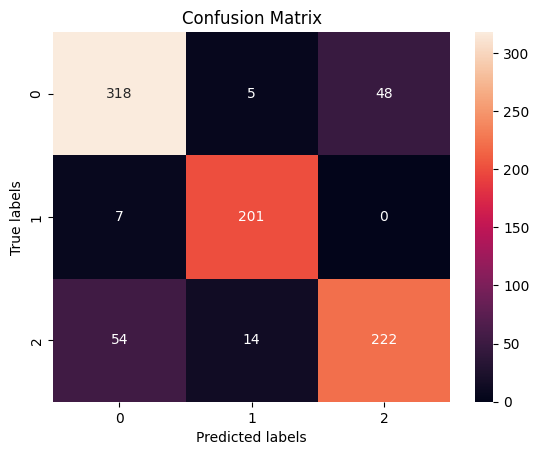

In [33]:
# Decision tree model

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, make_scorer

# Assuming you have a DataFrame named 'features' containing your sensor data
# and a Series named 'labels' containing the corresponding labels

X = sampled_df.drop('label', axis=1)
y = sampled_df['label']
dt_params = {'max_depth': list(np.arange(2, 22, 2)), 'min_samples_split': list(np.arange(5, 55, 5))}

tscv = TimeSeriesSplit(n_splits=5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
dt_model = DecisionTreeClassifier()
f1 = make_scorer(f1_score , average='macro')

dt_grid = GridSearchCV(dt_model, dt_params, cv=tscv, scoring=f1)

# Train the model on the training set
dt_grid.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_grid.predict(X_test)

# Evaluate the model
print("Decision Tree Best Parameters:", dt_grid.best_params_)
print("Decision Tree Best Score:", dt_grid.best_score_)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC AUC Score
preds = dt_grid.predict_proba(X_test)
auc_score = roc_auc_score(y_test, preds, multi_class='ovr')
print("ROC AUC Score:\n", auc_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1, 2]); ax.yaxis.set_ticklabels([0, 1 ,2]);

KNN Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN Best Score: 0.8444444754715217
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       371
           1       0.88      0.99      0.93       208
           2       0.82      0.90      0.86       290

    accuracy                           0.88       869
   macro avg       0.88      0.90      0.89       869
weighted avg       0.89      0.88      0.88       869

ROC AUC Score:
 0.9535321082275506
Confusion Matrix:
 <function confusion_matrix at 0x7f42cb86ad30>


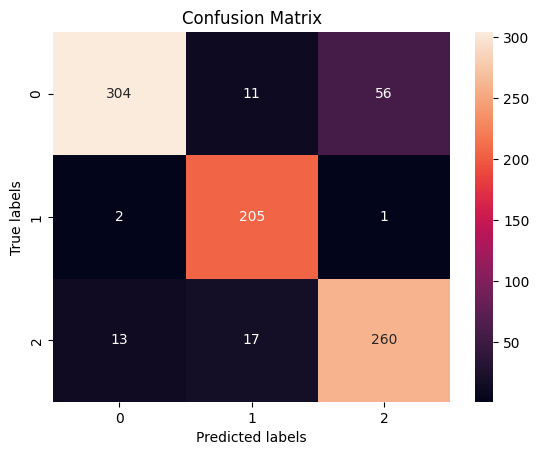

In [34]:
# KNN model

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, make_scorer

# Assuming you have a DataFrame named 'features' containing your sensor data
# and a Series named 'labels' containing the corresponding labels

X = sampled_df.drop('label', axis=1)
y = sampled_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Define the KNN model with fixed hyperparameters
tscv = TimeSeriesSplit(n_splits=5)
f1 = make_scorer(f1_score , average='macro')
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=tscv, scoring=f1)

# Train the model on the training set
knn_grid.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_grid.predict(X_test)

# Evaluate the model
print("KNN Best Parameters:", knn_grid.best_params_)
print("KNN Best Score:", knn_grid.best_score_)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC AUC Score
preds = knn_grid.predict_proba(X_test)
auc_score = roc_auc_score(y_test, preds, multi_class='ovr')
print("ROC AUC Score:\n", auc_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1, 2]); ax.yaxis.set_ticklabels([0, 1 ,2]);

In [35]:
# For the SVC, to get only two classes, we separate pre-ictal classes from 
# the rest in order to compare with the other classifiers.
sampled_df_svc = sampled_df.copy()
sampled_df_svc[sampled_df_svc['label'] == 1] = 0

sampled_df_svc['label'].value_counts()

0    1930
2     965
Name: label, dtype: int64

SVM Best Parameters: {'C': 10, 'kernel': 'rbf'}
SVM Best Score: 0.7210959280981539
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       579
           2       0.67      0.53      0.59       290

    accuracy                           0.75       869
   macro avg       0.73      0.70      0.71       869
weighted avg       0.75      0.75      0.75       869

ROC AUC Score:
 0.698162706211661
Confusion Matrix:
 <function confusion_matrix at 0x7f42cb86ad30>


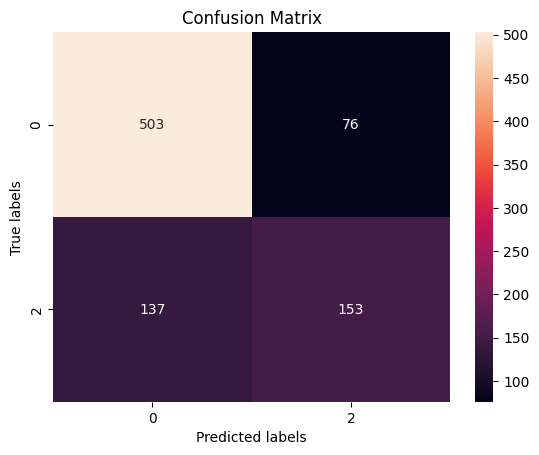

In [36]:
# SVM model

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, make_scorer

# Assuming you have a DataFrame named 'features' containing your sensor data
# and a Series named 'labels' containing the corresponding labels

X = sampled_df_svc.drop('label', axis=1)
y = sampled_df_svc['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the SVM model with fixed hyperparameters
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svm_model = SVC(probability=True)
tscv = TimeSeriesSplit(n_splits=5)
f1 = make_scorer(f1_score , average='macro')
svm_grid  = GridSearchCV(svm_model, svm_params, cv=tscv, scoring=f1)

# Train the model on the training set
svm_grid.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_grid.predict(X_test)

# Evaluate the model
print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC AUC Score
preds = svm_grid.predict(X_test)
auc_score = roc_auc_score(y_test, preds)# , multi_class='ovr')
print("ROC AUC Score:\n", auc_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 2]); ax.yaxis.set_ticklabels([0, 2]);

In [37]:
# Testing tsfresh features

# !pip install --upgrade scipy
# !pip install --upgrade tsfresh

# from tsfresh import extract_features
# from tsfresh.feature_extraction.settings import MinimalFCParameters